In [1]:
from tsai.all import *
import sklearn.metrics as skm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [2]:
df1 = pd.read_csv(r".\dataset\damage_detection_Vänersborg\type00.csv",index_col=0)
df2 = pd.read_csv(r".\dataset\damage_detection_Vänersborg\type01.csv",index_col=0)
df3 = pd.read_csv(r".\dataset\damage_detection_Vänersborg\type02.csv",index_col=0)

In [3]:
# 以下得到的y没有作用，将被覆盖
X, y = df2xy(pd.concat([df1[:176000], df2[:176000], df3[:176000]], ignore_index=True), data_cols=None)
# X, y = df2xy(df, data_cols=None)
X=X.reshape(1056,500,3)
X=np.transpose(X,(0,2,1))
label = [0] * 352+[1]*352+[2]*352
y = pd.DataFrame(label)

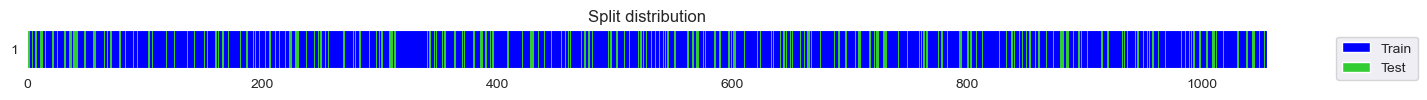

In [4]:
splits = get_splits(y,n_splits=1,valid_size = 0.25,test_size = 0,train_only=False,show_plot=True,check_splits=True,stratify=True, random_state=23, shuffle=True)

epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,1.012144,1.139355,0.329545,00:00
1,0.812399,0.963301,0.628788,00:00
2,0.627707,0.901078,0.609848,00:00
3,0.496590,0.743745,0.609848,00:00
4,0.417552,0.231666,0.905303,00:00
5,0.352843,0.444857,0.731061,00:00
6,0.305351,0.237848,0.890152,00:00
7,0.269246,0.207171,0.905303,00:00
8,0.246908,0.212508,0.890152,00:00
9,0.226287,0.218494,0.893939,00:00


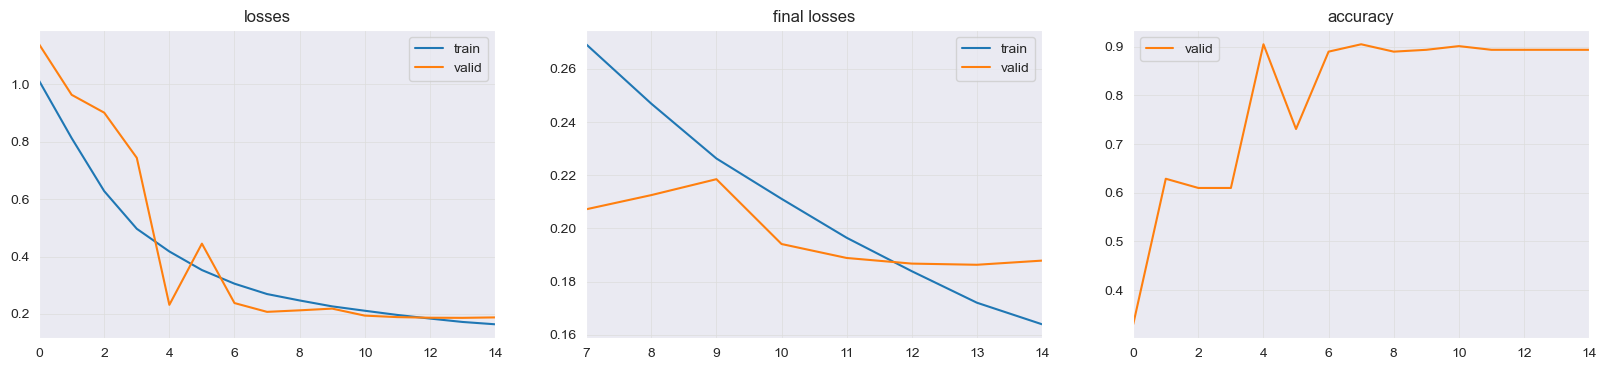

训练时间：2.9632606506347656 秒


In [5]:
# MLSTM_FCNPlus FCNPlus RNN_FCNPlus
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
model = TSClassifier(X, y.values, splits=splits, path='models', arch="FCNPlus", tfms=tfms, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
import time
# 记录训练开始时间
start_time = time.time()
model.fit_one_cycle(15, 0.001)
# 记录训练结束时间
end_time = time.time()
# 计算并打印训练时间
execution_time = end_time - start_time
print(f"训练时间：{execution_time} 秒")
model.export("stage1.pkl")

In [6]:
X2, y2 = df2xy(pd.concat([df1[176000:], df2[176000:], df3[176000:]], ignore_index=True), data_cols=None)
X2=X2.reshape(264,500,3)
X2=np.transpose(X2,(0,2,1))
label2 = [0] * 88+[1]*88+[2]*88
y2 = pd.DataFrame(label2)

In [8]:
from tsai.inference import load_learner

mv_clf = load_learner(r'.\models\stage1.pkl')
# 记录推理开始时间
start_time1 = time.time()
probas, target, preds = model.get_X_preds(X2[:264], y2.values[:264])
# 记录推理结束时间
end_time1 = time.time()
# 计算并打印推理时间
execution_time1 = end_time1 - start_time1
print(f"推理时间：{execution_time1} 秒")

推理时间：0.2308647632598877 秒


In [9]:
print(f'accuracy: {skm.accuracy_score(target.to("cpu").numpy().astype(int), preds.astype(int)):10.6f}')
print(f'precision: {skm.precision_score(target.to("cpu").numpy().astype(int), preds.astype(int), average="weighted"):10.6f}')
print(f'recall: {skm.recall_score(target.to("cpu").numpy().astype(int), preds.astype(int), average="weighted"):10.6f}')
print(f'f1: {skm.f1_score(target.to("cpu").numpy().astype(int), preds.astype(int), average="weighted"):10.6f}')

accuracy:   0.931818
precision:   0.938144
recall:   0.931818
f1:   0.929593


In [13]:
import pickle

# 假设 model 是你的模型实例
# 序列化模型
with open(r'.\models\stage1.pkl', 'wb') as f:
    pickle.dump(model, f)

# 计算文件大小
import os
file_size = os.path.getsize(r'.\models\stage1.pkl')
file_size_mb = file_size / (1024 * 1024)
print(f"模型文件大小：{file_size_mb} MB")

# 计算参数数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

params_count = count_parameters(model)
print(f"模型参数数量：{params_count // 1000}K")


模型文件大小：25.99114418029785 MB
模型参数数量：266K


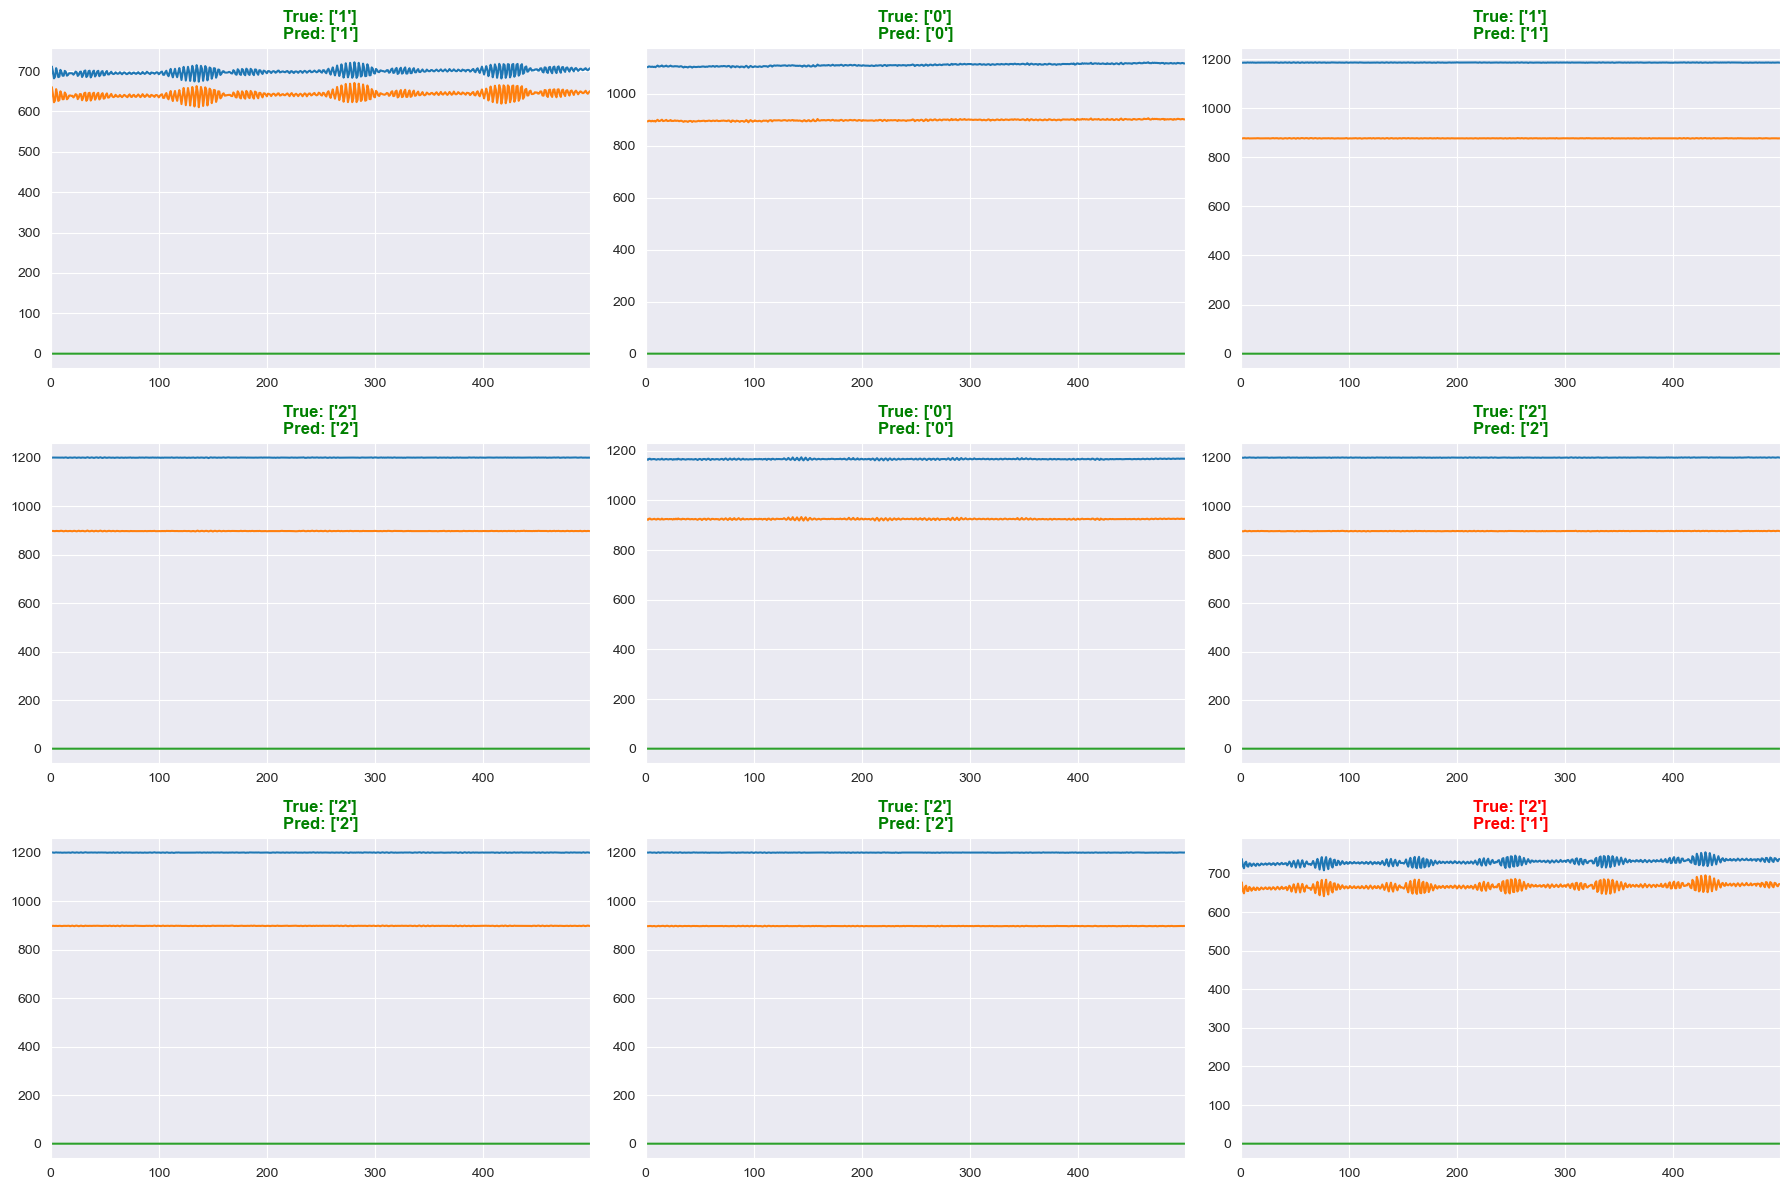

In [14]:
# 展示实际损伤分类和预测分类结果
model.show_results()

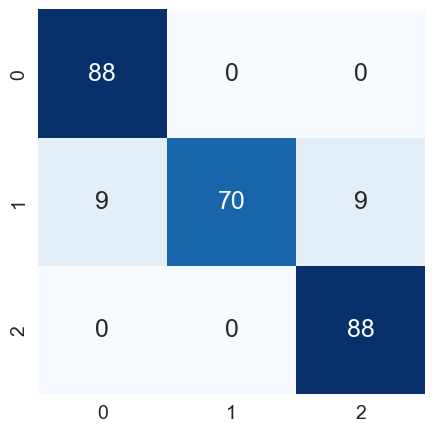

In [15]:
# interp = ClassificationInterpretation.from_learner(model)
# interp.plot_confusion_matrix()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(target.to("cpu").numpy().astype(int), preds.astype(int))

# 选择颜色方案
cmap = 'Blues'  # 或者 'Greys', 'binary'

# 使用 seaborn 绘制混淆矩阵
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,cbar=False,
            annot_kws={"size": 18})  # 设置注释文本的字体大小

# plt.title('Confusion Matrix', fontsize=20)  # 设置标题字体大小
# plt.ylabel('True Label', fontsize=16)  # 设置y轴标签字体大小
# plt.xlabel('Predicted Label', fontsize=16)  # 设置x轴标签字体大小

# 增大刻度标签字体大小
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

X.shape: (792, 3, 500)
y.shape: (792, 1)
Selected metric: accuracy
Computing feature importance (permutation method)...


  0 feature: BASELINE             accuracy: 0.931818


  0 feature: var_0                accuracy: 0.333333


  1 feature: var_1                accuracy: 0.330808


  2 feature: var_2                accuracy: 0.931818



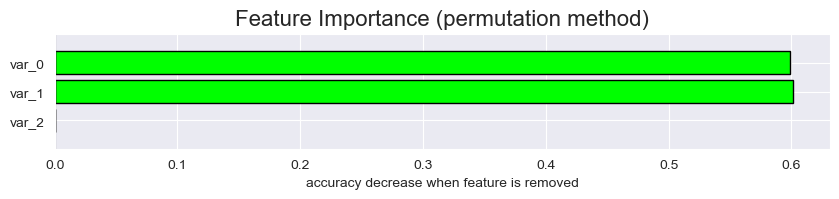

,Feature,accuracy,accuracy_change
0,var_1,0.330808,0.601010
1,var_0,0.333333,0.598485
2,BASELINE,0.931818,-0.000000
3,var_2,0.931818,-0.000000


In [16]:
model.feature_importance()

IndexError: index 1 is out of bounds for axis 0 with size 1

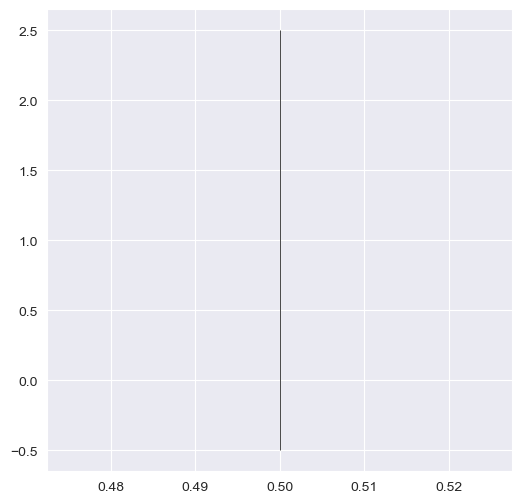

In [17]:
model.show_probas()


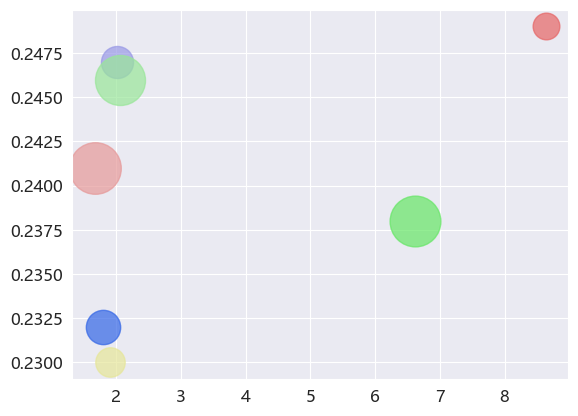

In [18]:
import matplotlib.pyplot as plt

# 设置中文字体和负号显示
plt.rcParams['font.family'] = ['Microsoft YaHei']  # 选择一个更美观的中文字体
plt.rcParams['font.size'] = 12  # 设置全局字体大小
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 数据：训练时间（秒），MAE误差，存储量（MB）和模型名称
# Jingui
# train_times = [6.22, 22.48, 28.83, 7.42, 5.50, 12.14, 6.30]  # 训练时间
# mae_errors = [0.340, 0.926, 1.081, 0.591, 0.693, 0.620, 0.301]  # MAE误差
# memory = [612, 1415, 414, 533, 1906, 1296, 449]  # 存储量，单位MB
# Bergsøysund
# train_times = [1.45,2.23,2.44,1.63,1.25,1.30,1.54]  # 训练时间
# mae_errors = [0.341, 0.357, 0.518, 0.427, 0.361, 0.308, 0.321]  # MAE误差
# memory = [612, 1335, 367, 533, 1389, 1296, 449]  # 存储量，单位MB
# Gjemnessund
# train_times = [5.93,19.61,20.55,6.33,5.42,5.17,6.12]  # 训练时间
# mae_errors = [0.043, 0.270, 1.994, 0.055, 0.045, 0.043, 0.032]  # MAE误差
# memory = [612, 1309, 354, 533, 1183, 1296, 449]  # 存储量，单位MB
# train_times = [5.93,6.33,5.42,5.17,6.12]  # 训练时间
# mae_errors = [0.043, 0.055, 0.045, 0.043, 0.032]  # MAE误差
# memory = [612, 533, 1183, 1296, 449]  # 存储量，单位MB
train_times = [1.80,6.61,8.64,2.01,1.67,2.05,1.90]  # 训练时间
mae_errors = [0.232, 0.238, 0.249, 0.247, 0.241, 0.246, 0.230]  # MAE误差
memory = [612, 1338, 370, 533, 1380, 1296, 449]  # 存储量，单位MB
# models = ['iTransformer', 'ModernTCN', 'TIDE', 'FreTS', 'RPTM']  # 模型名称
models = ['iTransformer', 'Informer', 'Reformer', 'ModernTCN', 'TIDE', 'FreTS', 'RPTM']  # 模型名称

# hell
# train_times = [0.788,1.902,1.663,17.478,0.789,16.407,2.681,1.428,2.150,1.530,2.243]  # 训练时间
# mae_errors = [0.660,0.644,0.576,0.529,0.646,0.587,0.614,0.656,0.659,0.510,0.666]  # MAE误差
# memory = [380.2,384.0,387.0,383.1,377.3,383.7,383.4,382.4,377.7,390.0,377.5]  # 存储量，单位MB
# models = ['FCN','InceptionTime','XceptionTime','MultiRocket','Hydra','HydraMultiRocket','TST','MALSTM-FCN','ConvTran','TransformerRNN','HCAN']  # 模型名称

# sweden
# train_times = [0.561,0.771,0.649,6.660,0.451,6.839,6.689,0.575,1.944,1.610,2.045]  # 训练时间
# mae_errors = [0.904,0.854,0.844,0.710,0.669,0.522,0.830,0.888,0.879,0.542,0.925]  # MAE误差
# memory = [26.0,30.4,34.5,24.8,23.3,25.1,30.5,31.6,25.4,37.4,25.1]  # 存储量，单位MB
# models = ['FCN','InceptionTime','XceptionTime','MultiRocket','Hydra','HydraMultiRocket','TST','MALSTM-FCN','ConvTran','TransformerRNN','HCAN']  # 模型名称


# 定义更鲜艳明亮的颜色方案
colors = [
    [0.2, 0.4, 0.9, 0.9],  # 明亮蓝色
    [0.4, 0.9, 0.4, 0.9],  # 明亮绿色
    [0.9, 0.4, 0.4, 0.9],  # 明亮红色
    [0.6, 0.6, 0.9, 0.9],  # 明亮紫色
    [0.9, 0.6, 0.6, 0.9],  # 明亮橙色
    [0.6, 0.9, 0.6, 0.9],  # 明亮青色
    [0.9, 0.9, 0.6, 0.9],  # 明亮黄色
    [0.8, 0.3, 0.9, 0.9],  # 明亮洋红色 (Magenta)
    [0.3, 0.8, 0.9, 0.9],  # 明亮天蓝色 (Sky Blue)
    [0.9, 0.8, 0.3, 0.9],  # 明亮金黄色 (Gold)
    [0.7, 0.9, 0.9, 0.9]   # 明亮浅蓝色 (Light Cyan)
]
alpha_value = 0.7  # 透明度值

# 绘制散点图，点的大小与存储量成正比，并使用不同的颜色和透明度 *15
for i, model in enumerate(models):
    plt.scatter([train_times[i]], [mae_errors[i]], s=memory[i], color=colors[i], alpha=alpha_value)

# 在每个点旁边标记模型的名称、存储量和训练时间
# for i, model in enumerate(models):
#     annotation = f"{model}\n（{train_times[i]:.2f}s,{memory[i]:.0f}MB）"
#     plt.annotate(annotation, (train_times[i], mae_errors[i]), textcoords="offset points", xytext=(0,0), ha='center', va='center')

# 添加网格线
plt.grid(True)

# 设置x轴的取值范围，例如从0到100
# plt.xlim(5.0, 9.0)
# 设置y轴的取值范围，例如从0到1
# plt.ylim(0.03, 0.09)

# 设置图表标题和坐标轴标签
# plt.title('效率比较', fontsize=14)  # 调整标题字体大小
# plt.xlabel('训练时间（s/epoch）', fontsize=12)  # 调整x轴标签字体大小
# plt.ylabel('均方误差', fontsize=12)  # 调整y轴标签字体大小

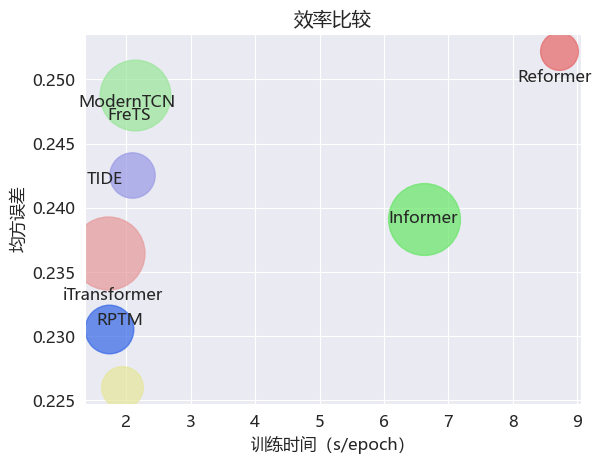

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# ... [保持之前的配置和数据定义不变]

# 定义更鲜艳明亮的颜色方案
colors = [
    [0.2, 0.4, 0.9, 0.7],  # 明亮蓝色
    [0.4, 0.9, 0.4, 0.7],  # 明亮绿色
    [0.9, 0.4, 0.4, 0.7],  # 明亮红色
    [0.6, 0.6, 0.9, 0.7],  # 明亮紫色
    [0.9, 0.6, 0.6, 0.7],  # 明亮橙色
    [0.6, 0.9, 0.6, 0.7],  # 明亮青色
    [0.9, 0.9, 0.6, 0.7],  # 明亮黄色
    [0.8, 0.3, 0.9, 0.7],  # 明亮洋红色 (Magenta)
    [0.3, 0.8, 0.9, 0.7],  # 明亮天蓝色 (Sky Blue)
    [0.9, 0.8, 0.3, 0.7],  # 明亮金黄色 (Gold)
    [0.7, 0.9, 0.9, 0.7]   # 明亮浅蓝色 (Light Cyan)
]

# 绘制散点图，点的大小与存储量成正比，并使用不同的颜色和透明度
max_size = max(memory) * 2  # 找到最大的点尺寸
for i, model in enumerate(models):
    size = min(memory[i] * 2, max_size)  # 确保没有点超过最大尺寸
    jitter_x = np.random.uniform(-0.1, 0.1)  # 添加抖动
    jitter_y = np.random.uniform(-0.005, 0.005)
    plt.scatter([train_times[i] + jitter_x], [mae_errors[i] + jitter_y], s=size, color=colors[i])

# 在每个点旁边标记模型的名称、存储量和训练时间 \n({train_times[i]:.2f}s,{memory[i]}MB)
for i, model in enumerate(models):
    annotation = f"{model}"
    plt.annotate(annotation, xy=(train_times[i], mae_errors[i]), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

# 添加网格线
plt.grid(True)

# 设置图表标题和坐标轴标签
plt.title('效率比较', fontsize=14)  # 调整标题字体大小
plt.xlabel('训练时间（s/epoch）', fontsize=12)  # 调整x轴标签字体大小
plt.ylabel('均方误差', fontsize=12)

plt.show()

In [20]:
import pandas as pd

# 读取原始CSV文件
input_file_path = r'D:\a_zyc_file\a-zouyuechao\graduation_thesis\experiment\time_series_forecasting\dataset\sweden\univariate.csv'
df = pd.read_csv(input_file_path)

# 以20行为间隔进行重采样
resampled_df = df.iloc[::50, :]
print(resampled_df.shape)

# 指定输出文件路径
output_file_path = r'D:\a_zyc_file\a-zouyuechao\graduation_thesis\experiment\time_series_forecasting\dataset\sweden\univariate2.csv'

# 将重采样的数据保存到新的CSV文件中
resampled_df.to_csv(output_file_path, index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\a_zyc_file\\a-zouyuechao\\graduation_thesis\\experiment\\time_series_forecasting\\dataset\\sweden\\univariate.csv'

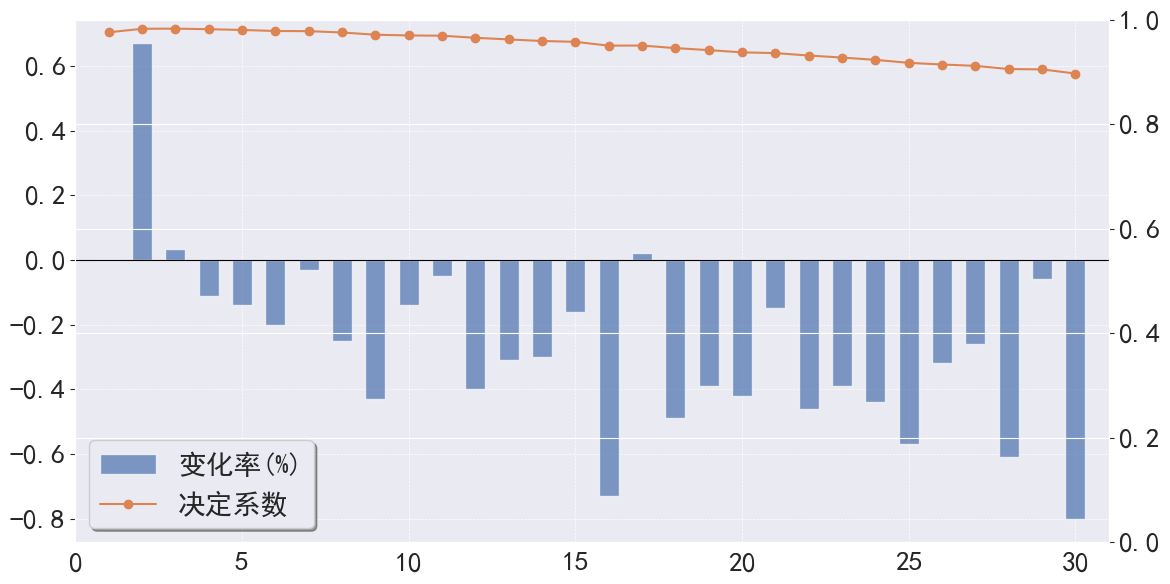

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 使用Seaborn库可以更方便地设置颜色
from matplotlib import rcParams
import matplotlib.font_manager as fm

# 查找系统上的中文字体，例如 'SimHei' 黑体, 'Microsoft YaHei' 微软雅黑等。
# 您可能需要根据自己的操作系统调整字体名称或路径。
# font = fm.FontProperties(fname='/path/to/your/chinese/font/file.ttf')  # 替换为实际字体文件路径
font = fm.FontProperties(family='SimHei')  # 如果字体已安装，可以直接指定字体名称

# 设置全局字体，如果上述方法不起作用，可以尝试以下方法：
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']  # 这里可以根据需要添加更多字体作为备选
rcParams['axes.unicode_minus'] = False  # 确保负号正常显示

# 提供的数据点（更新后）
data = {
    1: 0.9755149856209755,
    2: 0.9822142198681831,
    3: 0.982559323310852,
    4: 0.9814364463090897,
    5: 0.9800330642610788,
    6: 0.9780167173594236,
    7: 0.9776930809020996,
    8: 0.9751860871911049,
    9: 0.970893619582057,
    10: 0.9694993626326323,
    11: 0.9690,
    12: 0.9650,
    13: 0.9619,
    14: 0.9589,
    15: 0.9573,
    16: 0.9500,
    17: 0.9502,
    18: 0.9453,
    19: 0.9414,
    20: 0.9372,
    21: 0.9357,
    22: 0.9311,
    23: 0.9272,
    24: 0.9228,
    25: 0.9171,
    26: 0.9139,
    27: 0.9113,
    28: 0.9052,
    29: 0.9046,
    30: 0.8966
}

# 计算变化率
change_rates = [0]  # 第一个数据点没有前一个点可以比较
for i in range(2, len(data) + 1):
    change_rate = (data[i] - data[i-1]) * 100  # 变化率以百分比表示
    change_rates.append(change_rate)

# 创建图表
fig, ax1 = plt.subplots(figsize=(12, 6))

# 定义颜色
bar_color = sns.color_palette("deep")[0]  # 柱状图颜色（浅蓝色）
line_color = sns.color_palette("deep")[1]   # 折线图颜色（深红色）

# 绘制柱状图（变化率）
steps = list(data.keys())
ax1.bar(steps, change_rates, color=bar_color, label='变化率(%)', alpha=0.7, width=0.6)
ax1.axhline(0, color="black", linewidth=0.8)  # 添加一条水平线在y=0处

# 设置第二个y轴用于绘制R²分数的折线图
ax2 = ax1.twinx()

# 绘制折线图（R²值）
r2_scores = list(data.values())
ax2.plot(steps, r2_scores, marker='o', linestyle='-', color=line_color, label='决定系数')

# 添加标题和标签
# plt.title('不同预测长度下的R²分数和变化率', fontproperties=font, fontsize=14, fontweight='bold')
# ax1.set_xlabel('预测长度 (步数)', fontproperties=font, fontsize=12)
# ax1.set_ylabel('变化率 (%)', color=bar_color, fontproperties=font, fontsize=12)
# ax2.set_ylabel('R² 分数', color=line_color, fontproperties=font, fontsize=12)

# 设置右侧y轴的范围为0到1
ax2.set_ylim(0, 1)
ax2.set_xlim(0, 31)

# 设置网格
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

font = {'size': 20}

# 设置图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,loc='lower left',  frameon=True, fancybox=True, shadow=True, prop=font)

# 设置刻度标签颜色与对应的轴颜色一致
ax1.tick_params(axis='y',  labelsize=20)
ax2.tick_params(axis='y',  labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

# 显示图表
plt.tight_layout()
plt.show()